---
date: last-modified
---

# TEMPO O3 validation

**This notebook illustrates comparison of TEMPO ozone total column retrievals with Pandora ground stations and DSCOVR EPIC retrievals.**
In this notebook:

- It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibility to select the station within TEMPO's field of regard (FOR). If the selected station is outside the FOR, no TEMPO time series will be generated.

- The user chooses a time period of interest, by providing start and end dates in the form `YYYYMMDD`. Please be aware that if the selected period of interest is outside the available time span of one of the sensors, the corresponding time series will not be generated.

- DSCOVR L2 O3 data are interpolated to the location of the selected Pandora station.

- Data files for all 3 sensors are downloaded on-the-fly. TEMPO and DSCOVR data are downloaded with earthaccess library that needs to be installed first.

- TEMPO data files are read by means of netCDF library that needs to be installed first.

- Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read ozone total column along with its total uncertainty.

- The resulting time series are plotted with and without uncertainty of Pandora measurement in the end of the notebook. Unlike TEMPO NO2 and HCHO retrievals, O3 retrievals do not have uncertainty written in the files.
DSCOVR data files also do not have uncertainty of O3 retrievals.

- This notebook was tested on `TEMPO_O3TOT_L2_V03`, `DSCOVR_EPIC_L2_TO3_03`, and Pandora `L2_rout2p1-8` data files.

## Prerequisites

- earthaccess
- h5py
- matplotlib
- netCDF4
- numpy
- scipy
- shapely

### Notebook Authors / Affiliation

Alex Radkevich / Atmospheric Science Data Center (ASDC)

# 1 Installing and importing necessary libraries

In [45]:
import codecs  # needed to read Pandora data
import os
import platform
import requests  # needed to search for and download Pandora data
import shutil
import sys
from datetime import datetime  # needed to work with time in plotting time series
from pathlib import Path  # needed to check whether a needed data file is already downloaded
from subprocess import Popen
from urllib.request import urlopen  # needed to search for and download Pandora data

import earthaccess  # needed to discover and download TEMPO data
import matplotlib.pyplot as plt  # needed to plot the resulting time series
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np

from scipy.interpolate import griddata  # needed to interpolate TEMPO data to the point of interest
from scipy import stats  # needed for linear regression analysis
from shapely.geometry import Point, Polygon  # needed to search a point within a polygon

import h5py  # needed to read DSCOVR_EPIC_L2_TO3 files

# 2 Define functions to work with TEMPO, Pandora, and DSCOVR data

# 2.1 functions to work with Pandora

### 2.1.1 function creating the list of available Pandora sites

In [46]:
def read_pandora_web():
    url = "https://data.pandonia-global-network.org/"
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")

    big_line = str(html)
    lines = big_line.split("\n")

    ref_lines = [i for i in lines if "href" in i]
    refs = []
    for line in ref_lines:
        pos1 = line.find('"')
        pos2 = line.rfind('"')
        if 0 < pos1 < pos2 and line[pos2 - 1] == "/" and line[pos1 + 1] == ".":
            refs.append(line[pos1 + 3 : pos2 - 1])

    return refs

### 2.1.2 functions allowing user to choose a Pandora site of interest

In [47]:
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
    site_list = []
    for line in refs:
        if site_name in line:
            site_list.append(line)

    return site_list


# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
    print("please select a Pandora site name from the list")
    for ref in refs:
        print(ref)

    answer = "y"
    while answer == "y":
        site_name = input("Enter a name of a Pandora site: ")
        print(site_name)
        site_list = check_site(site_name, refs)
        site_num = len(site_list)
        if site_num == 0:
            print("site ", site_name, "was not found")
            continue

        if site_num > 1:
            print("there are ", site_num, " site names, select one from")
            for site in site_list:
                print(site)

            site_name = input("Enter an exact name of a Pandora site: ")
            if site_list.count(site_name) != 1:
                print("Entered name is not the exact match of one of the following sites")
                for site in site_list:
                    print(site)
                print("program terminated")
                sys.exit()

            for site in site_list:
                if site == site_name:
                    pandora_site = site_name
                    print("site ", site_name, "was found and added to the list of sites ")
                    break

        if site_num == 1:
            pandora_site = site_list[0]
            print("site ", site_list[0], "was found and added to the list of sites ")

        answer = "n"

    return pandora_site

### 2.1.3 function creating the list links to O3 data files at the selected Pandora site

In [48]:
# Pandora site may have several instruments. In this case each instrument has its own directory.
# However, the most recent version of the O3 data, rout2p1_8, is available only in one of these directories.
# The function creates all possible links, but some of them may be non-existing. This is checked and cleared later.
def instrument_path(site):
    url = "https://data.pandonia-global-network.org/" + site + "/"
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")
    html_len = len(html)

    pos1 = 0
    big_line = str(html)
    lines = big_line.split("\n")

    ref_lines = [i for i in lines if "href" in i]
    links = []
    for line in ref_lines:
        pos1 = line.find('"')
        pos2 = line.rfind('"')
        if 0 < pos1 < pos2 and line[pos2 - 1] == "/" and line[pos1 + 3 : pos1 + 10] == "Pandora":
            link = (
                url
                + line[pos1 + 3 : pos2]
                + "L2/"
                + line[pos1 + 3 : pos2 - 1]
                + "_"
                + site
                + "_L2_rout2p1-8.txt"
            )
            print(link)
            links.append(link)

    return links


# Defining functions downloading Pandora data file with given url
def download(url):
    response = requests.get(url)
    response_code = response.status_code

    file_name = url.split("/")[-1]

    if response_code == 200:
        content = response.content
        data_path = Path(file_name)
        data_path.write_bytes(content)

    return file_name, response_code

### 2.1.4 functions reading Pandora O3 data file rout2p1-8

In [49]:
# function read_timestamp converts Pandora timestamp of the format
# 'yyyymmddThhmmssZ' into a set of 6 numbers:
# integer year, month, day, hour, minute, and real second.
def read_timestamp(timestamp):
    yyyy = int(timestamp[0:4])
    mm = int(timestamp[4:6])
    dd = int(timestamp[6:8])
    hh = int(timestamp[9:11])
    mn = int(timestamp[11:13])
    ss = float(timestamp[13:17])

    return yyyy, mm, dd, hh, mn, ss


# function read_Pandora_O3_rout2p1_8. It is to be used for the future validation efforts.
# The difference with the original version is that instead of discriminating negative values of the total O3 column,
# it uses quality flags. It was previously found that QF == 0 does not occure often enough,
# so we will have to use QF == 10 (not-assured high quality).
#
# function read_Pandora_O3_rout2p1_8 reads Pandora total O3 column data files ending with rout2p1-8.
# Arguments:
# fname - name file to be read, string;
# start_date - beginning of the time interval of interest,
#              integer of the form YYYYMMDD;
# end_date -   end of the time interval of interest,
#              integer of the form YYYYMMDD.
#
# if start_date is greater than end_date, the function returns a numpy array
# with shape (0, 8), otherwise it returns an 8-column numpy array
# with with columns being year, month, day, hour, minute, second of observation
# and retrieved total O3 column along with its total uncertainty.
#
# O3 column and its uncertainties are in mol/m^2, so conversion to Dobson Units is
# performed by multiplication by DU_conversion = 1./4.4615E-04
def read_Pandora_O3_rout2p1_8_v2(fname, start_date, end_date):
    DU_conversion = 1.0 / 4.4615e-04

    data = np.empty([0, 8])
    if start_date > end_date:
        return -999.0, -999.0, data

    with codecs.open(fname, "r", encoding="utf-8", errors="ignore") as f:
        while True:
            # Get next line from file
            line = f.readline()

            if line.find("Short location name:") >= 0:
                loc_name = line.split()[-1]  # location name, to be used in the output file name
                print("location name ", loc_name)

            if line.find("Location latitude [deg]:") >= 0:
                lat = float(line.split()[-1])  # location latitude
                print("location latitude ", lat)

            if line.find("Location longitude [deg]:") >= 0:
                lon = float(line.split()[-1])  # location longitude
                print("location longitude ", lon)

            if line.find("--------") >= 0:
                break

        while True:
            # Get next line from file
            line = f.readline()

            if line.find("--------") >= 0:
                break

        while True:
            # now reading line with data
            line = f.readline()

            if not line:
                break

            line_split = line.split()

            yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
            date_stamp = yyyy * 10000 + mm * 100 + dd
            if date_stamp < start_date or date_stamp > end_date:
                continue

            QF = int(line_split[35])  # quality flag

            if QF == 0 or QF == 10:
                column = float(line_split[38])
                #        column_unc = float(line_split[42]) # Total uncertainty of ozone total vertical column amount [moles per square meter]
                column_unc = float(
                    line_split[43]
                )  # rms-based uncertainty of ozone total vertical column amount [moles per square meter]
                data = np.append(
                    data,
                    [
                        [
                            yyyy,
                            mm,
                            dd,
                            hh,
                            mn,
                            ss,
                            column * DU_conversion,
                            column_unc * DU_conversion,
                        ]
                    ],
                    axis=0,
                )

    return lat, lon, loc_name, data

# 2.2 function to read DSCOVR O3 data files

In [50]:
def read_epic_l2_to3(fname):
    # function read_epic_l2_to3 reads DSCOVR_EPIC_L2_TO3 product file given by its fname
    # and returns arrays of 2D latitudes and longitudes, and total O3 column
    # along with their fill values and time.

    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    try:
        with h5py.File(fname, "r") as f:
            item = f["Latitude"]
            lat2D = item[:]
            #    fv_geo = item.fillvalue
            fv_geo = lat2D[0, 0]

            item = f["Longitude"]
            lon2D = item[:]

            item = f["Ozone"]
            o3_2D = item[:]
            # commented out line below is the general way to read the fill value
            # however, attribute '_FillValue' is not set for any array in the current version of the product
            # at the same time, arrays do have apparent fill values that can be seen in the
            # corners of the image
            #    fv_o3 = item.fillvalue
            fv_o3 = o3_2D[0, 0]

        # getting time from the granule's filename
        fname_split = fname.split("_")
        timestamp = fname_split[-2]
        yyyy = int(timestamp[0:4])
        mm = int(timestamp[4:6])
        dd = int(timestamp[6:8])
        hh = int(timestamp[8:10])
        mn = int(timestamp[10:12])
        ss = int(timestamp[12:14])

    except:
        print("Unable to find or read hdf5 input granule file ", fname)
        lat2D = 0.0
        lon2D = 0.0
        o3_2D = 0.0
        fv_o3 = 0.0
        fv_geo = 0.0
        yyyy = 0
        mm = 0
        dd = 0
        hh = 0
        mn = 0
        ss = 0

    return lat2D, lon2D, o3_2D, fv_o3, fv_geo, yyyy, mm, dd, hh, mn, ss

# 2.3 function reading TEMPO_O3TOT_L2

In [51]:
def read_TEMPO_O3TOT_L2(fn):
    """
    function read_TEMPO_O3TOT_L2 reads the following arrays from the
    TEMPO L2 O3 product TEMPO_O3TOT_L2_V03:
      column_amount_o3;
      quality_flag.
    It returns respective fields along with coordinates of the pixels.

    If one requested variables cannot be read, all returned variables are zeroed
    """
    var_name = "column_amount_o3"
    var_QF_name = "quality_flag"

    try:
        ds = nc.Dataset(fn)

        prod = ds.groups["product"]  # this opens group product, /product, as prod

        var = prod.variables[
            var_name
        ]  # this reads variable column_amount_o3 from prod (group product, /product)
        total_O3_column = np.array(var)
        fv_prod = var.getncattr("_FillValue")
        prod_unit = var.getncattr("units")

        var_QF = prod.variables[
            var_QF_name
        ]  # this reads variable column_amount_o3 from prod (group product, /product)
        total_O3_column_QF = np.array(var_QF)

        geo = ds.groups["geolocation"]  # this opens group geolocation, /geolocation, as geo

        lat = np.array(
            geo.variables["latitude"]
        )  # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
        lon = np.array(
            geo.variables["longitude"]
        )  # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
        fv_geo = geo.variables["latitude"].getncattr("_FillValue")
        time = np.array(
            geo.variables["time"]
        )  # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

    except:
        print("variable " + var_name + " cannot be read in file " + fn)
        lat = 0.0
        lon = 0.0
        fv_geo = 0.0
        time = 0.0
        total_O3_column = 0.0
        total_O3_column_QF = 0.0
        fv_prod = 0.0
        prod_unit = ""

    return lat, lon, fv_geo, time, total_O3_column, total_O3_column_QF, fv_prod, prod_unit

## 2.4 auxiliary functions to handle data

### 2.4.1 function smoothing Pandora retievals and interpolating them onto TEMPO times of observations

In [52]:
# Smooth Pandora retievals and interplate them into other time series times
# Pandora timeseries has significantly more data points then TEMPO and DSCOVR. It is also very noisy.
# To make comparison easier, Pandora timeseries is interpolated to the moments of TEMPO and DSCOVR observations.

# Interpolation is performed by the function defined below with the help of Gaussian smooting as follow:
# x_int(t) = SUM(x_p(t_i)*wt(t_i, t)),
#
# wt(t_i, t) = exp(-(t - t_i)^2/(2 * sigma^2))/SUM(exp(-(t - t_i)^2/(2 * sigma^2))),
#
# where sums are taken over times t_i falling into time interval (t-dt_max, t+dt_max).
#
# Parameters dt_max and sigma can be chosen by the user.
def gauss_interpolation(timeseries, new_times):
    #
    # function gauss_interpolation takes 2D array timeseries with function
    # to be interpolated and 1D array new_times containing times to which
    # the function is to be interpolated
    # arguments:
    #     timeseries - array with at least 2 columns,
    #                  1st column - times, 2nd (3rd, ...) column(s) - function to be interpolated
    #     new_times  - 1D array of times to which the function(s) to be interpolated
    #
    # parameters
    # dt_max = 0.0028125 - 4 minutes 3 seconds (243 seconds) expressed in days
    # sigma = 0.0009375 - 1 minute 21 seconds (81 seconds) expressed in days

    dt_max = 0.0028125  # 4 minutes 3 seconds (243 seconds) expressed in days
    sigma = 0.0009375  # 1 minute 21 seconds (81 seconds) expressed in days

    nnt = len(new_times)
    (nt, nfun) = timeseries.shape

    timeseries_smooth = np.empty([0, nfun])
    data_subset = np.empty(nnt, dtype=object)
    cnt = 0
    for new_time in new_times:
        llim = new_time - dt_max
        ulim = new_time + dt_max

        timeseries_subset = timeseries[((timeseries[:, 0] < ulim) & (timeseries[:, 0] > llim))]
        if len(timeseries_subset) < 1:
            continue
        t_delta = timeseries_subset[:, 0] - new_time
        wt = np.exp(-(t_delta**2) / (2.0 * sigma**2))
        wt = wt / np.sum(wt)
        timeseries_subset = np.append(timeseries_subset, np.transpose([wt]), axis=1)
        for t in timeseries_subset:
            print(f"{t[0]:.1f} {t[1]:.3e} {t[2]:.2e} {t[3]:.4e}")
        data_subset[cnt] = timeseries_subset
        cnt += 1

        timeseries_smooth_loc = np.array([new_time])
        for ifun in range(1, nfun):
            timeseries_smooth_loc = np.append(
                timeseries_smooth_loc, np.sum(timeseries_subset[:, ifun] * wt)
            )
        print(
            f"{timeseries_smooth_loc[0]:.1f} {timeseries_smooth_loc[1]:.3e} {timeseries_smooth_loc[2]:.2e}\n"
        )

        timeseries_smooth = np.append(timeseries_smooth, np.array([timeseries_smooth_loc]), axis=0)

    return timeseries_smooth, data_subset

### 2.4.2 function computing linear regression with zero intercept

In [53]:
# custom made function regress_0intercept takes vectors x and y
# representing coordinates and function values at these coordinates
# and returns slope of regression fit y = a*x
# along with coefficient of determination
def regress_0intercept(x, y):
    success = False

    if len(x) != len(y):
        a = 0.0
        R2 = 0.0

    elif len(x) == 1:
        if x[0] != 0.0:
            a = y[0] / x[0]
            R2 = 1.0
            success = True
        else:
            if y[0] != 0.0:
                a = np.inf
                R2 = 1.0
                success = True
            else:
                a = np.inf
                R2 = 0.0

    else:
        xy_sum = np.dot(x, y)
        x2_sum = np.dot(x, x)
        a = xy_sum / x2_sum

        res_y = y - a * x
        res_sum_2 = np.dot(res_y, res_y)
        y2_sum = np.dot(y, y)
        sum_tot_2 = y2_sum - len(y) * np.mean(y) ** 2
        R2 = 1.0 - res_sum_2 / sum_tot_2

        success = True

    return success, a, R2

# Main code begins here

# 3 Establishing access to EarthData

## 3.1 Logging in

In [54]:
# Establishing access to EarthData
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

## 3.2 Creating local directory

In [55]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + ".dodsrc", "w") as file:
    file.write("HTTP.COOKIEJAR={}.urs_cookies\n".format(homeDir))
    file.write("HTTP.NETRC={}.netrc".format(homeDir))
    file.close()

print("Saved .dodsrc to:", homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen("chmod og-rw ~/.netrc", shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + ".dodsrc", os.getcwd())
    print("Copied .dodsrc to:", os.getcwd())

Saved .dodsrc to: /home/jovyan/


# 4 Working with Pandora data

## 4.1 Discovering existing Pandora stations and selecting one of them

In [56]:
# Discovering available Pandora site.
# Please bear in mind that some sites do not have NO2 data files
print("gathering Pandora sites information")
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs)  # create list of Pandora sites of interest
print("the following sites were selected")
print(pandora_site)
print("from the list of existing Pandora sites")

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
    pandora_fname = link.split("/")[-1]

    # check if file exists in the local directory, if not download from Pandora site
    if not os.path.exists(pandora_fname):
        print(pandora_fname, " does not exit in local directory, downloading from the web")
        print(link)

        pandora_fname, response_code = download(link)

        if response_code == 200:
            print("Pandora L2 file ", pandora_fname, " has been downloaded")
            npfiles = npfiles + 1
            pandora_files.append(pandora_fname)
        else:
            print("Pandora L2 file ", link, " does not exist")

    else:
        print(pandora_fname, " exits in local directory")
        npfiles = npfiles + 1
        pandora_files.append(pandora_fname)

if npfiles == 0:  # no files were found, STOP here
    print("no files were found for Pandora site ", pandora_site, "program terminated")
    sys.exit()
if npfiles > 1:  # normally there should be only one file per site. if there are more - STOP
    #  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
    print("there are more than 1 files for site ", pandora_site)
    #  for pandora_fname in pandora_files: print(pandora_fname)
    for i, link in enumerate(links):
        print(i, link)
    num = int(input("please enter the number for the link"))
    pandora_fname, response_code = download(links[num])

gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
ArlingtonTX
Athens-NOA
AtlantaGA-Conyers
AtlantaGA-GATech
AtlantaGA-SouthDeKalb
AtlantaGA
AustinTX
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
Calakmul
calibrationfiles
CambridgeBay
CambridgeMA
CameronLA
CapeElizabethME
Cebu
ChapelHillNC
CharlesCityVA
ChelseaMA
ChiangMai
ChicagoIL
Cologne
ComodoroRivadavia
Cordoba
CornwallCT
CorpusChristiTX
Daegu
Dalanzadgad
Davos
DearbornMI
DeBilt
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
EssexMD
Eureka-0PAL
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
FortYatesND
Fukuoka
Gongju-KNU
Granada
GrandForksND
GreenbeltMD
Haldwani-ARIES
HamptonVA-HU
HamptonVA
Heidelberg
Helsinki
HoustonTX-SanJacinto
HoustonTX
HuntsvilleAL
Ilocos
Incheon-ESC
Innsbruck
IowaCityIA-WHS
Islamabad-NUST
Iza

Enter a name of a Pandora site:  Hous


Hous
there are  2  site names, select one from
HoustonTX-SanJacinto
HoustonTX


Enter an exact name of a Pandora site:  HoustonTX


site  HoustonTX was found and added to the list of sites 
the following sites were selected
HoustonTX
from the list of existing Pandora sites
https://data.pandonia-global-network.org/HoustonTX/Pandora25s1/L2/Pandora25s1_HoustonTX_L2_rout2p1-8.txt
Pandora25s1_HoustonTX_L2_rout2p1-8.txt  does not exit in local directory, downloading from the web
https://data.pandonia-global-network.org/HoustonTX/Pandora25s1/L2/Pandora25s1_HoustonTX_L2_rout2p1-8.txt
Pandora L2 file  Pandora25s1_HoustonTX_L2_rout2p1-8.txt  has been downloaded


## 4.2 Selecting timeframe of interest common for all instruments

In [57]:
print("enter period of interest, start and end dates, in the form YYYYMMDD")
datestamp_ini = input("enter start date of interest ")
datestamp_fin = input("enter end date of interest ")

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date // 10000
mm_ini = start_date // 100 - yyyy_ini * 100
dd_ini = start_date - yyyy_ini * 10000 - mm_ini * 100

yyyy_fin = end_date // 10000
mm_fin = end_date // 100 - yyyy_fin * 100
dd_fin = end_date - yyyy_fin * 10000 - mm_fin * 100
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str("%4.4i-%2.2i-%2.2i 00:00:00" % (yyyy_ini, mm_ini, dd_ini))
date_end = str("%4.4i-%2.2i-%2.2i 23:59:59" % (yyyy_fin, mm_fin, dd_fin))

enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20230901
enter end date of interest  20230901


2023 9 1 2023 9 1


## 4.3 Reading Pandora file within selected timeframe and create point of interest

In [58]:
pandora_file = pandora_files[0]
lat, lon, POI_name, Pandora_data = read_Pandora_O3_rout2p1_8_v2(pandora_file, start_date, end_date)

if lat == -999.0:
    print("error reading pandora file ", pandora_file, "program terminated")
    sys.exit()

POI = np.array([lat, lon])

# print # of points in Pandora timeseries
n_Pandora_data = len(Pandora_data)
print(
    n_Pandora_data,
    " Pandora measurements found within period of interes between",
    date_start,
    "and",
    date_end,
)
if n_Pandora_data == 0:
    print("program terminated")
    sys.exit()

location name  HoustonTX
location latitude  29.72
location longitude  -95.34
67  Pandora measurements found within period of interes between 2023-09-01 00:00:00 and 2023-09-01 23:59:59


## 4.4 Setting TEMPO and DSCOVR name constants and writing Pandora timeseries to a file

In [59]:
# Setting TEMPO name constants
short_name_TEMPO = "TEMPO_O3TOT_L2"  # collection name to search for in the EarthData
out_Q = "O3_tot_col_TEMPO"  # name of the output quantity with unit

# Setting TEMPO name constants
short_name_DSCOVR = "DSCOVR_EPIC_L2_TO3"  # collection name to search for in the EarthData
out_Q_EPIC = "O3_tot_col_EPIC"

out_Q_Pandora = "O3_tot_col_Pandora"

out_Q_unit = "DU"

# write Pandora timeseries to a file
POI_name_ = POI_name.replace(" ", "_")

Pandora_out = open(
    out_Q_Pandora
    + "_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "w",
)
for line in Pandora_data:
    Pandora_out.write(
        str(
            "%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e %12.4e\n"
            % (line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7])
        )
    )
Pandora_out.close()

# 5 Working with DSCOVR data

## 5.1 Searching for DSCOVR data files in the selected thimeframe and download them

In [60]:
POI_lat = POI[0]
POI_lon = POI[1]
bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)

POI_results_EPIC = earthaccess.search_data(
    short_name=short_name_DSCOVR, temporal=(date_start, date_end), bounding_box=bbox
)

n_EPIC = len(POI_results_EPIC)

print(
    "total number of DSCOVR EPIC L2_TO3 granules found for POI",
    POI_name,
    "\nwithin period of interes between",
    date_start,
    "and",
    date_end,
    "\nis",
    n_EPIC,
)

# lines below before the call of earthaccess.download()
# check whether all found granules have download links.
# granules without links are removed from the list of search results
# without this step, those granules crash the call of earthaccess.download()
granule_links_EPIC = []
POI_results_EPIC_bad = []
for result in POI_results_EPIC:
    try:
        granule_links_EPIC.append(result["umm"]["RelatedUrls"][0]["URL"])
    except:
        POI_results_EPIC_bad.append(result)

for granule_link in granule_links_EPIC:
    print(granule_link)
for result in POI_results_EPIC_bad:
    POI_results_EPIC.remove(result)

downloaded_files = earthaccess.download(
    POI_results_EPIC,
    local_path=".",
)

# Checking whether all DSCOVR EPIC data files have been downloaded
for granule_link in granule_links_EPIC:
    EPIC_fname = granule_link.split("/")[-1]
    # check if file exists in the local directory
    if not os.path.exists(EPIC_fname):
        print(EPIC_fname, "does not exist in local directory")
        # repeat attempt to download
        downloaded_files = earthaccess.download(granule_link, local_path=".")
        # if file still does not exist in the directory, remove its link from the list of links
        if not os.path.exists(EPIC_fname):
            granule_links_EPIC.remove(granule_link)

Granules found: 12
total number of DSCOVR EPIC L2_TO3 granules found for POI HoustonTX 
within period of interes between 2023-09-01 00:00:00 and 2023-09-01 23:59:59 
is 12
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901013240_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901133241_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901143809_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901185959_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901164904_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901175431_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901034335_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_202309010

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

## 5.2 Compiling DSCOVR EPIC total ozone timeseries

In [61]:
geo_deviation = 0.1  # deviation from the point of interest, degree

fout = open(
    out_Q_EPIC
    + "_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "w",
)
fout.write(
    "timeseries of "
    + out_Q_EPIC
    + " at "
    + POI_name
    + " "
    + str("%08.4fN %08.4fW" % (POI[0], -POI[1]))
    + "\n"
)
fout.write("yyyy mm dd hh mn ss " + out_Q_unit + "\n")

# for result in POI_results_EPIC:
for granule_link in sorted(granule_links_EPIC):
    last_slash_ind = granule_link.rfind("/")
    fname = granule_link[last_slash_ind + 1 :]
    print("\n" + fname)
    lat2D, lon2D, o3_2D, fv_o3, fv_geo, yyyy, mm, dd, hh, mn, ss = read_epic_l2_to3(fname)

    # remove file after reading.
    # If DSCOVR EPIC granules are not needed for the future use, uncomment the line below.
    #  os.remove(EPIC_fname)

    if isinstance(lat2D, float):
        continue

    nx = lon2D.shape[0]
    ny = lon2D.shape[1]

    # check whether POI is in the granule. If not - move to the next granule
    mask = (
        (lat2D < POI_lat + geo_deviation)
        & (lat2D > POI_lat - geo_deviation)
        & (lon2D < POI_lon + geo_deviation)
        & (lon2D > POI_lon - geo_deviation)
        & (o3_2D != fv_o3)
        & (o3_2D > 0.0)
    )
    lat_loc = lat2D[mask]
    lon_loc = lon2D[mask]
    o3_loc = o3_2D[mask]
    n_loc = len(o3_loc)
    if n_loc < 1:
        continue

    pp = np.array([POI[1], POI[0]])
    points = np.empty([0, 2])
    ff = np.empty(0)

    for i in range(n_loc):
        if o3_loc[i] == fv_o3 or o3_loc[i] < 0:
            continue
        points = np.append(points, [[lon_loc[i], lat_loc[i]]], axis=0)
        ff = np.append(ff, o3_loc[i])

    try:
        [prod_loc] = griddata(points, ff, pp, method="linear", fill_value=-1.0, rescale=False)
    except:
        try:
            prod_loc = np.mean(ff)
        except:
            continue
    if prod_loc == -1.0:
        continue

    print(yyyy, mm, dd, hh, mn, ss, prod_loc)

    fout.write(
        str("%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e " % (yyyy, mm, dd, hh, mn, ss, prod_loc))
    )
    for i in range(n_loc):
        fout.write(str("%9.4fN %9.4fW %10.3e " % (lat_loc[i], -lon_loc[i], o3_loc[i])))
    fout.write("\n")

fout.close()


DSCOVR_EPIC_L2_TO3_03_20230901002713_03.h5
2023 9 1 0 27 13 197.65826416015625

DSCOVR_EPIC_L2_TO3_03_20230901013240_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901023807_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901034335_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901044902_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901055429_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901133241_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901143809_03.h5
2023 9 1 14 38 9 290.3342923630935

DSCOVR_EPIC_L2_TO3_03_20230901154336_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901164904_03.h5
2023 9 1 16 49 4 291.2684049027054

DSCOVR_EPIC_L2_TO3_03_20230901175431_03.h5
2023 9 1 17 54 31 287.2359102557148

DSCOVR_EPIC_L2_TO3_03_20230901185959_03.h5
2023 9 1 18 59 59 294.6995527886286


# 6 Working with TEMPO data

## 6.1 Searching TEMPO data files containing the POI (position of the Pandora station)

In [62]:
# Searching TEMPO data files within 0.5 degree range around the POI (position of the Pandora station)
auth = earthaccess.login()
auth.refresh_tokens()

POI_lat = POI[0]
POI_lon = POI[1]

version = "V03"
POI_results = earthaccess.search_data(
    short_name=short_name_TEMPO,
    version=version,
    temporal=(date_start, date_end),
    point=(POI_lon, POI_lat),
)
n_gr = len(POI_results)

if n_gr == 0:
    print("program terminated")
    sys.exit()

Granules found: 14


## 6.2 Printing explicit links to the granules and downloading the files

In [63]:
# Printing explicit links to the granules.
granule_links = []
for result in POI_results:
    granule_links.append(result["umm"]["RelatedUrls"][0]["URL"])
for granule_link in granule_links:
    print(granule_link)
    TEMPO_fname = granule_link.split("/")[-1]
    if os.path.exists(TEMPO_fname):
        continue
    downloaded_files = earthaccess.download(granule_link, local_path=".")

# Downloading TEMPO data files
# downloaded_files = earthaccess.download(
#    POI_results,
#    local_path='.')

# Checking whether all TEMPO data files have been downloaded
for granule_link in granule_links:
    TEMPO_fname = granule_link.split("/")[-1]
    # check if file exists in the local directory
    if not os.path.exists(TEMPO_fname):
        print(TEMPO_fname, "does not exist in local directory")
        # repeat attempt to download
        downloaded_files = earthaccess.download(granule_link, local_path=".")
        # if file still does not exist in the directory, remove its link from the list of links
        if not os.path.exists(TEMPO_fname):
            granule_links.remove(granule_link)

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T000908Z_S018G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T004031Z_S019G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T011154Z_S020G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T143537Z_S007G06.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T153808Z_S008G06.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T165326Z_S009G08.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T181516Z_S010G08.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T194812Z_S011G06.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T205043Z_S012G06.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T215314Z_S013G06.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T222440Z_S015G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T225603Z_S016G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T232726Z_S017G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/2023.09.01/TEMPO_O3TOT_L2_V03_20230901T235849Z_S018G01.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## 6.3 Compiling TEMPO ozone total column time series

In [64]:
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

fout_HiQ = open(
    out_Q
    + "_HiQ_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "w",
)
fout_HiQ.write(
    "timeseries of "
    + out_Q
    + " at "
    + POI_name
    + " "
    + str("%08.4fN %08.4fW" % (POI[0], -POI[1]))
    + "\n"
)
fout_HiQ.write("yyyy mm dd hh mn ss " + out_Q_unit + "\n")

fout_AllQ = open(
    out_Q
    + "_AllQ_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "w",
)
fout_AllQ.write(
    "timeseries of "
    + out_Q
    + " at "
    + POI_name
    + " "
    + str("%08.4fN %08.4fW" % (POI[0], -POI[1]))
    + "\n"
)
fout_AllQ.write("yyyy mm dd hh mn ss " + out_Q_unit + "\n")

for granule_link in sorted(granule_links):
    TEMPO_fname = granule_link.split("/")[-1]
    print("\ngranule ", TEMPO_fname)
    lat, lon, fv_geo, time, total_O3_column, total_O3_column_QF, fv_prod, prod_unit = (
        read_TEMPO_O3TOT_L2(TEMPO_fname)
    )

    # remove TEMPO granule after reading
    # If TEMPO granules are not needed for the future use, uncomment the line below.
    #  os.remove(TEMPO_fname)

    if isinstance(lat, float):
        continue

    nx = lon.shape[0]
    ny = lon.shape[1]

    # getting time from the granule filename.
    # This time corresponds to the 1st element of array time above which is GPS time in seconds
    Tind = TEMPO_fname.rfind("T")
    yyyy = int(TEMPO_fname[Tind - 8 : Tind - 4])
    mm = int(TEMPO_fname[Tind - 4 : Tind - 2])
    dd = int(TEMPO_fname[Tind - 2 : Tind])
    hh = int(TEMPO_fname[Tind + 1 : Tind + 3])
    mn = int(TEMPO_fname[Tind + 3 : Tind + 5])
    ss = float(TEMPO_fname[Tind + 5 : Tind + 7])

    pp = np.array([POI[1], POI[0]])
    p = Point(pp)  # POI[0] - latitudes, POI[1] - longitudes

    POI_found = False
    for ix in range(nx - 1):
        for iy in range(ny - 1):
            if lon[ix, iy] == fv_geo:
                continue
            if lat[ix, iy] == fv_geo:
                continue
            if lon[ix, iy + 1] == fv_geo:
                continue
            if lat[ix, iy + 1] == fv_geo:
                continue
            if lon[ix + 1, iy + 1] == fv_geo:
                continue
            if lat[ix + 1, iy + 1] == fv_geo:
                continue
            if lon[ix + 1, iy] == fv_geo:
                continue
            if lat[ix + 1, iy] == fv_geo:
                continue

            coords_poly_loc = [
                [lon[ix, iy], lat[ix, iy]],
                [lon[ix, iy + 1], lat[ix, iy + 1]],
                [lon[ix + 1, iy + 1], lat[ix + 1, iy + 1]],
                [lon[ix + 1, iy], lat[ix + 1, iy]],
            ]
            poly_loc = Polygon(coords_poly_loc)

            if p.within(poly_loc):
                print("scanl pixel latitude longitude O3_col O3_col_QF")
                for scl in range(ix, ix + 2, 1):
                    for pix in range(iy, iy + 2, 1):
                        print(
                            "  %3d %4d %9.6f %10.6f %5.1f %6i"
                            % (
                                scl,
                                pix,
                                lat[scl, pix],
                                lon[scl, pix],
                                total_O3_column[scl, pix],
                                total_O3_column_QF[scl, pix],
                            )
                        )

                POI_found = True
                print("POI", POI_name, "at", POI[1], POI[0], " found")

                total_O3_column_loc = np.array(
                    [
                        total_O3_column[ix, iy],
                        total_O3_column[ix, iy + 1],
                        total_O3_column[ix + 1, iy + 1],
                        total_O3_column[ix + 1, iy],
                    ]
                )
                total_O3_column_QF_loc = np.array(
                    [
                        total_O3_column_QF[ix, iy],
                        total_O3_column_QF[ix, iy + 1],
                        total_O3_column_QF[ix + 1, iy + 1],
                        total_O3_column_QF[ix + 1, iy],
                    ]
                )
                lat_loc = np.array(
                    [lat[ix, iy], lat[ix, iy + 1], lat[ix + 1, iy + 1], lat[ix + 1, iy]]
                )
                lon_loc = np.array(
                    [lon[ix, iy], lon[ix, iy + 1], lon[ix + 1, iy + 1], lon[ix + 1, iy]]
                )
                mask_noFV = total_O3_column_loc != fv_prod
                mask_HiQ = (total_O3_column_QF_loc == 0) & mask_noFV
                mask_AllQ = (
                    (total_O3_column_QF_loc == 0)
                    | (total_O3_column_QF_loc == 1)
                    | (total_O3_column_QF_loc == 4)
                    | (total_O3_column_QF_loc == 128)
                ) & mask_noFV

                points_HiQ = np.column_stack((lon_loc[mask_HiQ], lat_loc[mask_HiQ]))
                ff_HiQ = total_O3_column_loc[mask_HiQ]

                points_AllQ = np.column_stack((lon_loc[mask_AllQ], lat_loc[mask_AllQ]))
                ff_AllQ = total_O3_column_loc[mask_AllQ]

                points = np.empty([0, 2])
                ff = np.empty(0)

                # handling time first:
                delta_t = (time[ix + 1] + time[ix]) * 0.5 - time[0]
                ss = ss + delta_t
                if ss >= 60.0:
                    delta_mn = int(ss / 60.0)
                    ss = ss - 60.0 * delta_mn
                    mn = mn + delta_mn
                    if mn >= 60:
                        mn = mn - 60
                        hh = hh + 1
                        if hh == 24:
                            hh = hh - 24
                            dd = dd + 1
                            day_month = days[mm]
                            if (yyyy // 4) * 4 == yyyy and mm == 2:
                                day_month = day_month + 1
                            if dd > day_month:
                                dd = 1
                                mm = mm + 1
                                if mm > 12:
                                    mm = 1
                                    yyyy = yyyy + 1

                if ff_AllQ.shape[0] == 0:
                    continue
                elif ff_AllQ.shape[0] < 4:
                    total_O3_column_AllQ = np.mean(ff_AllQ)
                elif ff_AllQ.shape[0] == 4:
                    total_O3_column_AllQ = griddata(
                        points_AllQ, ff_AllQ, pp, method="linear", fill_value=-1.0, rescale=False
                    )[0]
                if total_O3_column_AllQ == -1.0:
                    continue

                fout_AllQ.write(
                    str(
                        "%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e "
                        % (yyyy, mm, dd, hh, mn, ss, total_O3_column_AllQ)
                    )
                )
                fout_AllQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (lat[ix, iy], -lon[ix, iy], total_O3_column[ix, iy])
                    )
                )
                fout_AllQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (lat[ix, iy + 1], -lon[ix, iy + 1], total_O3_column[ix, iy + 1])
                    )
                )
                fout_AllQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (
                            lat[ix + 1, iy + 1],
                            -lon[ix + 1, iy + 1],
                            total_O3_column[ix + 1, iy + 1],
                        )
                    )
                )
                fout_AllQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e\n"
                        % (lat[ix + 1, iy], -lon[ix + 1, iy], total_O3_column[ix + 1, iy])
                    )
                )

                if ff_HiQ.shape[0] == 0:
                    continue
                elif ff_HiQ.shape[0] < 4:
                    total_O3_column_HiQ = np.mean(ff_HiQ)
                elif ff_HiQ.shape[0] == 4:
                    total_O3_column_HiQ = griddata(
                        points_HiQ, ff_HiQ, pp, method="linear", fill_value=-1.0, rescale=False
                    )[0]
                if total_O3_column_HiQ == -1.0:
                    continue

                fout_HiQ.write(
                    str(
                        "%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e "
                        % (yyyy, mm, dd, hh, mn, ss, total_O3_column_HiQ)
                    )
                )
                fout_HiQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (lat[ix, iy], -lon[ix, iy], total_O3_column[ix, iy])
                    )
                )
                fout_HiQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (lat[ix, iy + 1], -lon[ix, iy + 1], total_O3_column[ix, iy + 1])
                    )
                )
                fout_HiQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e "
                        % (
                            lat[ix + 1, iy + 1],
                            -lon[ix + 1, iy + 1],
                            total_O3_column[ix + 1, iy + 1],
                        )
                    )
                )
                fout_HiQ.write(
                    str(
                        "%9.4fN %9.4fW %10.3e\n"
                        % (lat[ix + 1, iy], -lon[ix + 1, iy], total_O3_column[ix + 1, iy])
                    )
                )

                break

        if POI_found:
            break

fout_AllQ.close()
fout_HiQ.close()


granule  TEMPO_O3TOT_L2_V03_20230901T000908Z_S018G01.nc
scanl pixel latitude longitude O3_col O3_col_QF
   84 1245 29.730993 -95.333527 306.1      2
   84 1246 29.714136 -95.332695 293.7      2
   85 1245 29.731018 -95.380981 266.0      2
   85 1246 29.714169 -95.380142 259.1      2
POI HoustonTX at -95.34 29.72  found

granule  TEMPO_O3TOT_L2_V03_20230901T004031Z_S019G01.nc
scanl pixel latitude longitude O3_col O3_col_QF
   83 1245 29.726822 -95.308746 -1000000015047466219876688855040.0    655
   83 1246 29.709970 -95.307922 -1000000015047466219876688855040.0    655
   84 1245 29.727169 -95.355675 -1000000015047466219876688855040.0    647
   84 1246 29.710320 -95.354843 -1000000015047466219876688855040.0    647
POI HoustonTX at -95.34 29.72  found

granule  TEMPO_O3TOT_L2_V03_20230901T011154Z_S020G01.nc
scanl pixel latitude longitude O3_col O3_col_QF
   83 1244 29.730303 -95.305435 -1000000015047466219876688855040.0   4743
   83 1245 29.713465 -95.304611 -1000000015047466219876688855

# 7 Plotting the results

## 7.1 Reading created data files for TEMPO, create timeseries

In [65]:
# Plotting the results
# Reading created data files for TEMPO and DSCOVR, create timeseries

fout_AllQ = open(
    out_Q
    + "_AllQ_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "r",
)

header1_AllQ = fout_AllQ.readline()
header2_AllQ = fout_AllQ.readline()
data_lines_AllQ = fout_AllQ.readlines()

fout_HiQ = open(
    out_Q
    + "_HiQ_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "r",
)

header1_HiQ = fout_HiQ.readline()
header2_HiQ = fout_HiQ.readline()
data_lines_HiQ = fout_HiQ.readlines()

fout_AllQ.close()
fout_HiQ.close()

yyyy = yyyy_ini
mm = mm_ini
dd = dd_ini
hh = 0
mn = 0
ss = 0
dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

yyyy = yyyy_fin
mm = mm_fin
dd = dd_fin
hh = 23
mn = 59
ss = 59
dt_fin = datetime(
    yyyy, mm, dd, hh, mn, ss
)  # this is time 1 second before the end of the timeframe of interest

time_series_TEMPO_HiQ = np.empty([0, 2])

if len(data_lines_HiQ) > 0:
    for line in data_lines_HiQ:
        split = line.split()
        yyyy = int(split[0])
        mm = int(split[1])
        dd = int(split[2])
        hh = int(split[3])
        mn = int(split[4])
        ss = int(split[5])
        # dt below is time since the beginning of the eriod of interest in hours
        dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds() / 86400.0
        time_series_TEMPO_HiQ = np.append(time_series_TEMPO_HiQ, [[dt, float(split[6])]], axis=0)

time_series_TEMPO_AllQ = np.empty([0, 2])

if len(data_lines_AllQ) > 0:
    for line in data_lines_AllQ:
        split = line.split()
        yyyy = int(split[0])
        mm = int(split[1])
        dd = int(split[2])
        hh = int(split[3])
        mn = int(split[4])
        ss = int(split[5])
        # dt below is time since the beginning of the eriod of interest in hours
        dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds() / 86400.0
        time_series_TEMPO_AllQ = np.append(time_series_TEMPO_AllQ, [[dt, float(split[6])]], axis=0)

if len(time_series_TEMPO_AllQ) == 0 and len(time_series_TEMPO_HiQ) == 0:
    print("TEMPO timeseries does not have data. STOP")
    sys.exit()

## 7.2 creating DSCOVR timeseries

In [66]:
# reading DSCOVR file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, and O3 column
fout = open(
    out_Q_EPIC
    + "_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "r",
)

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

time_series_DSCOVR = np.empty([0, 2])

if len(data_lines) > 0:
    for line in data_lines:
        split = line.split()
        yyyy = int(split[0])
        mm = int(split[1])
        dd = int(split[2])
        hh = int(split[3])
        mn = int(split[4])
        ss = int(split[5])
        # dt below is time since the beginning of the eriod of interest in hours
        dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds() / 86400.0
        time_series_DSCOVR = np.append(time_series_DSCOVR, [[dt, float(split[6])]], axis=0)

## 7.3 read saved Pandora file and create timeseries

In [67]:
Pandora_out = open(
    out_Q_Pandora
    + "_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name_
    + "_"
    + str("%08.4fN_%08.4fW.txt" % (POI[0], -POI[1])),
    "r",
)
Pandora_data_lines = Pandora_out.readlines()
Pandora_out.close()

time_series_Pandora = np.empty([0, 3])

for line in Pandora_data_lines:
    split = line.split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = int(split[2])
    hh = int(split[3])
    mn = int(split[4])
    ss = int(float(split[5]))
    microsec = int((float(split[5]) - ss) * 1000000)
    # dt below is time since the beginning of the period of interest in hours
    dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds() / 86400.0
    time_series_Pandora = np.append(
        time_series_Pandora, [[dt, float(split[6]), float(split[7])]], axis=0
    )

## 7.4 Plotting timeseries

### 7.4.1 No error bars

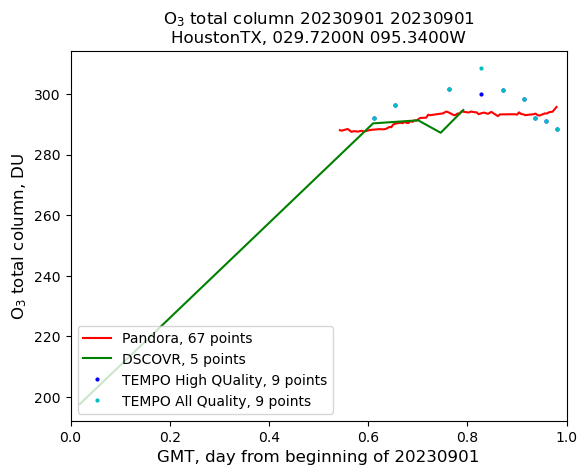

In [68]:
# No error bars
plot_title = "O$_{3}$ total column " + datestamp_ini + " " + datestamp_fin + "\n" + POI_name
img_name = "O3_tot_col_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".jpg"

plt.plot(
    time_series_Pandora[:, 0],
    time_series_Pandora[:, 1],
    label=f"Pandora, {len(time_series_Pandora)} points",
    c="r",
)
plt.plot(
    time_series_DSCOVR[:, 0],
    time_series_DSCOVR[:, 1],
    label=f"DSCOVR, {len(time_series_DSCOVR)} points",
    c="g",
)
plt.plot(
    time_series_TEMPO_HiQ[:, 0],
    time_series_TEMPO_HiQ[:, 1],
    label=f"TEMPO High QUality, {len(time_series_TEMPO_HiQ)} points",
    c="b",
    marker=".",
    linestyle="",
    markersize=4,
)
plt.plot(
    time_series_TEMPO_AllQ[:, 0],
    time_series_TEMPO_AllQ[:, 1],
    label=f"TEMPO All Quality, {len(time_series_TEMPO_AllQ)} points",
    c="c",
    marker=".",
    markersize=4,
    linestyle="",
)

# Set the range of x-axis
l_lim = 0.0
u_lim = ((dt_fin - dt0).total_seconds() + 1.0) / 86400.0
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
# Set the range of y-axis
# l_lim = 275
# u_lim = 375
# plt.ylim(l_lim, u_lim)

plt.xlabel(r"GMT, day from beginning of " + datestamp_ini, fontsize=12)
plt.ylabel("O$_{3}$ total column, " + out_Q_unit, fontsize=12)

plt.legend(loc="lower left")

plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
plt.savefig(img_name, format="jpg", dpi=300)

### 7.4.2 Plotting TEMPO and smoothed Pandora retievals with error bars

(67, 3)
(9, 2)
(9, 2)
(5, 2)
0.8 2.939e+02 7.33e+00 1.0000e+00
0.8 2.939e+02 7.33e+00

0.8 2.937e+02 6.78e+00 1.0000e+00
0.8 2.937e+02 6.78e+00

0.9 2.933e+02 5.06e+00 1.4800e-01
0.9 2.930e+02 4.96e+00 8.5200e-01
0.9 2.930e+02 4.98e+00

0.9 2.935e+02 4.49e+00 1.0000e+00
0.9 2.935e+02 4.49e+00

1.0 2.936e+02 5.50e+00 1.6531e-01
1.0 2.935e+02 1.09e+01 8.3469e-01
1.0 2.935e+02 1.00e+01

1.0 2.957e+02 2.11e+01 1.0000e+00
1.0 2.957e+02 2.11e+01

0.8 2.939e+02 7.33e+00 1.0000e+00
0.8 2.939e+02 7.33e+00

0.8 2.937e+02 6.78e+00 1.0000e+00
0.8 2.937e+02 6.78e+00

0.9 2.933e+02 5.06e+00 1.4800e-01
0.9 2.930e+02 4.96e+00 8.5200e-01
0.9 2.930e+02 4.98e+00

0.9 2.935e+02 4.49e+00 1.0000e+00
0.9 2.935e+02 4.49e+00

1.0 2.936e+02 5.50e+00 1.6531e-01
1.0 2.935e+02 1.09e+01 8.3469e-01
1.0 2.935e+02 1.00e+01

1.0 2.957e+02 2.11e+01 1.0000e+00
1.0 2.957e+02 2.11e+01

0.6 2.882e+02 4.91e+00 1.0000e+00
0.6 2.882e+02 4.91e+00



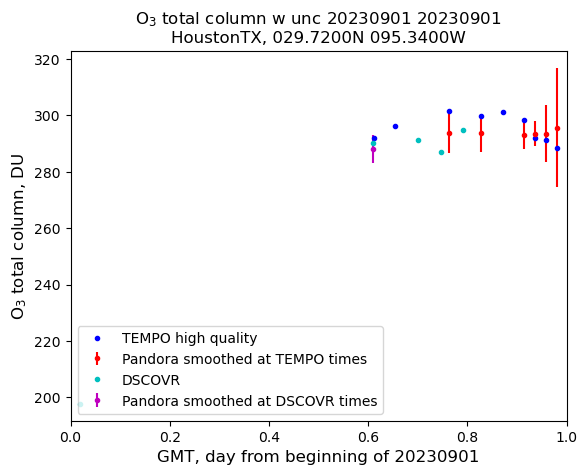

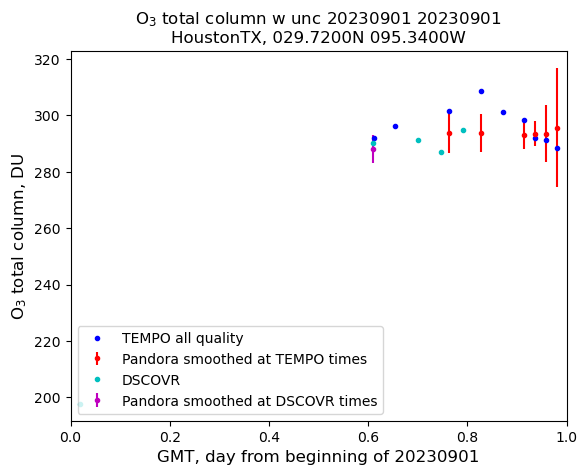

In [69]:
print(time_series_Pandora.shape)
print(time_series_TEMPO_HiQ.shape)
print(time_series_TEMPO_AllQ.shape)
print(time_series_DSCOVR.shape)

timeseries_Pandora_TEMPO_HiQ, data_subset_TEMPO_HiQ = gauss_interpolation(
    time_series_Pandora[:, 0:3], time_series_TEMPO_HiQ[:, 0]
)

timeseries_Pandora_TEMPO_AllQ, data_subset_TEMPO_AllQ = gauss_interpolation(
    time_series_Pandora[:, 0:3], time_series_TEMPO_AllQ[:, 0]
)

timeseries_Pandora_DSCOVR, data_subset_DSCOVR = gauss_interpolation(
    time_series_Pandora[:, 0:3], time_series_DSCOVR[:, 0]
)

if len(time_series_TEMPO_HiQ) > 0:
    plot_title = (
        "O$_{3}$ total column w unc " + datestamp_ini + " " + datestamp_fin + "\n" + POI_name
    )
    img_name = (
        "O3_tot_col_HiQ_unc_" + "_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".jpg"
    )

    fig = plt.figure()

    plt.errorbar(
        time_series_TEMPO_HiQ[:, 0],
        time_series_TEMPO_HiQ[:, 1],
        yerr=None,
        label="TEMPO high quality",
        c="b",
        ls="",
        marker=".",
    )

    plt.errorbar(
        timeseries_Pandora_TEMPO_HiQ[:, 0],
        timeseries_Pandora_TEMPO_HiQ[:, 1],
        yerr=timeseries_Pandora_TEMPO_HiQ[:, 2],
        label="Pandora smoothed at TEMPO times",
        c="r",
        ls="",
        marker=".",
    )

    plt.errorbar(
        time_series_DSCOVR[:, 0],
        time_series_DSCOVR[:, 1],
        yerr=None,
        label="DSCOVR",
        c="c",
        ls="",
        marker=".",
    )

    plt.errorbar(
        timeseries_Pandora_DSCOVR[:, 0],
        timeseries_Pandora_DSCOVR[:, 1],
        yerr=timeseries_Pandora_DSCOVR[:, 2],
        label="Pandora smoothed at DSCOVR times",
        c="m",
        ls="",
        marker=".",
    )

    # Set the range of x-axis
    l_lim = 0.0
    u_lim = ((dt_fin - dt0).total_seconds() + 1.0) / 86400.0
    plt.xlim(l_lim, u_lim)

    # Set the range of y-axis
    # l_lim = 275
    # u_lim = 375
    # plt.ylim(l_lim, u_lim)

    plt.xlabel(r"GMT, day from beginning of " + datestamp_ini, fontsize=12)
    plt.ylabel("O$_{3}$ total column, " + out_Q_unit, fontsize=12)

    plt.legend(loc="lower left")

    plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
    plt.savefig(img_name, format="jpg", dpi=300)
#  plt.close()

if len(time_series_TEMPO_AllQ) > 0:
    plot_title = (
        "O$_{3}$ total column w unc " + datestamp_ini + " " + datestamp_fin + "\n" + POI_name
    )
    img_name = (
        "O3_tot_col_AllQ_unc_" + "_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".jpg"
    )

    fig = plt.figure()

    plt.errorbar(
        time_series_TEMPO_AllQ[:, 0],
        time_series_TEMPO_AllQ[:, 1],
        yerr=None,
        label="TEMPO all quality",
        c="b",
        ls="",
        marker=".",
    )

    plt.errorbar(
        timeseries_Pandora_TEMPO_AllQ[:, 0],
        timeseries_Pandora_TEMPO_AllQ[:, 1],
        yerr=timeseries_Pandora_TEMPO_AllQ[:, 2],
        label="Pandora smoothed at TEMPO times",
        c="r",
        ls="",
        marker=".",
    )

    plt.errorbar(
        time_series_DSCOVR[:, 0],
        time_series_DSCOVR[:, 1],
        yerr=None,
        label="DSCOVR",
        c="c",
        ls="",
        marker=".",
    )

    plt.errorbar(
        timeseries_Pandora_DSCOVR[:, 0],
        timeseries_Pandora_DSCOVR[:, 1],
        yerr=timeseries_Pandora_DSCOVR[:, 2],
        label="Pandora smoothed at DSCOVR times",
        c="m",
        ls="",
        marker=".",
    )

    # Set the range of x-axis
    l_lim = 0.0
    u_lim = ((dt_fin - dt0).total_seconds() + 1.0) / 86400.0
    plt.xlim(l_lim, u_lim)

    # Set the range of y-axis
    # l_lim = 275
    # u_lim = 375
    # plt.ylim(l_lim, u_lim)

    plt.xlabel(r"GMT, day from beginning of " + datestamp_ini, fontsize=12)
    plt.ylabel("O$_{3}$ total column, " + out_Q_unit, fontsize=12)

    plt.legend(loc="lower left")

    plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
    plt.savefig(img_name, format="jpg", dpi=300)
#  plt.close()

## 7.5 Plotting scatter plots along with regressions

### 7.5.1 TEMPO

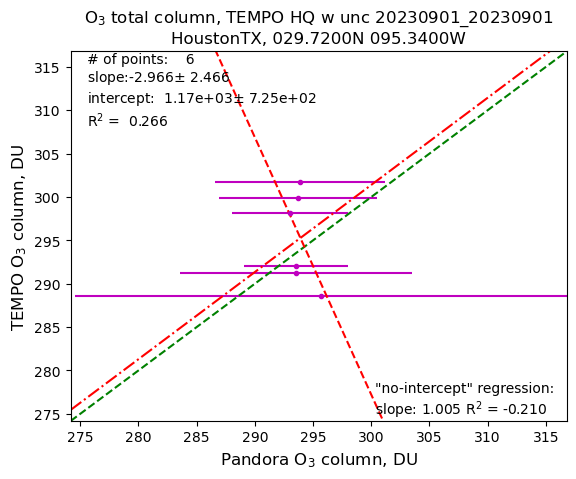

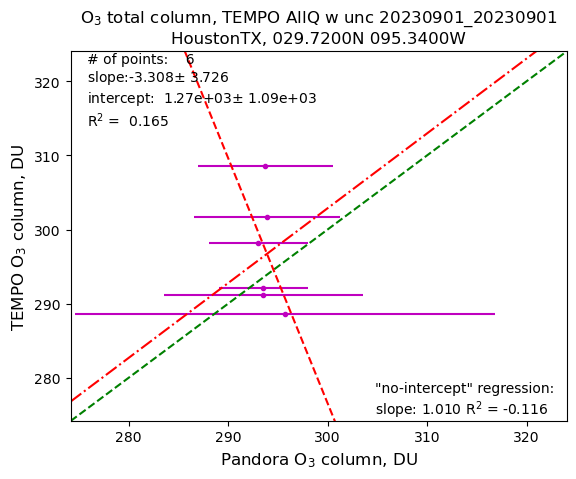

In [70]:
TEMPO_Pandora_scatter_HiQ = np.empty([0, 3])
for td in time_series_TEMPO_HiQ:
    for pd in timeseries_Pandora_TEMPO_HiQ:
        if td[0] == pd[0]:
            TEMPO_Pandora_scatter_HiQ = np.append(
                TEMPO_Pandora_scatter_HiQ, [[pd[1], td[1], pd[2]]], axis=0
            )
            break

if len(TEMPO_Pandora_scatter_HiQ) == 0:
    print(
        "TEMPO high quality and Pandora time series has less than 2 simultaneous measurements.\n"
        + "Potential cause for this problem is scarcity of TEMPO pixels with QF == 0.\n"
        + "The TEMPO science team recommends using only data with QF == 0.\n"
        + "Users may overcome the restriction on the quality flag set in section 6.3,\n"
        + 'find "total_O3_column_QF_loc == 0" there. By doing so users assume risks of using low quality data.\n'
        + "The problem of very scarse QF==0 pixels was previously documented.\n"
        + "There is nothing to plot here, this block is terminated.\n"
        + "Users may continue with DSCOVR EPIC vs. Pandora plot in the next section"
    )
    sys.exit()

regress = stats.linregress(TEMPO_Pandora_scatter_HiQ[:, 0], TEMPO_Pandora_scatter_HiQ[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept = regress_0intercept(
    TEMPO_Pandora_scatter_HiQ[:, 0], TEMPO_Pandora_scatter_HiQ[:, 1]
)

plot_title = (
    "O$_{3}$ total column, TEMPO HQ w unc " + datestamp_ini + "_" + datestamp_fin + "\n" + POI_name
)
img_name = (
    "TEMPO_HiQ_vs_Pandora_scatter_O3_tot_col_unc_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name
    + ".jpg"
)

fig = plt.figure()

plt.errorbar(
    TEMPO_Pandora_scatter_HiQ[:, 0],
    TEMPO_Pandora_scatter_HiQ[:, 1],
    xerr=TEMPO_Pandora_scatter_HiQ[:, 2],
    c="m",
    ls="",
    marker=".",
)

plt.xlabel(r"Pandora O$_{3}$ column, DU", fontsize=12)
plt.ylabel(r"TEMPO O$_{3}$ column, DU", fontsize=12)

fig.text(
    0.15,
    0.725,
    f"# of points: {len(TEMPO_Pandora_scatter_HiQ):4d}\nslope:{slope: 6.3f}$\pm${stderr: 6.3f}\nintercept: {intercept: 8.2e}$\pm${intercept_stderr: 8.2e}\nR$^{2}$ = {r2:6.3f}",
)

# Set the range of x-axis
l_lim = min(TEMPO_Pandora_scatter_HiQ[:, [0, 1]].flatten()) * 0.95
u_lim = max(TEMPO_Pandora_scatter_HiQ[:, [0, 1]].flatten()) * 1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim], c="g", ls="--")

plt.plot([l_lim, u_lim], [l_lim * slope + intercept, u_lim * slope + intercept], c="r", ls="--")

if success:
    plt.plot([l_lim, u_lim], [l_lim * slope_0intercept, u_lim * slope_0intercept], c="r", ls="-.")
    fig.text(
        0.6,
        0.125,
        f'"no-intercept" regression:\nslope:{slope_0intercept: 6.3f} R$^{2}$ = {r2_0intercept:6.3f}',
    )

plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
plt.savefig(img_name, format="jpg", dpi=300)

TEMPO_Pandora_scatter_AllQ = np.empty([0, 3])
for td in time_series_TEMPO_AllQ:
    for pd in timeseries_Pandora_TEMPO_AllQ:
        if td[0] == pd[0]:
            TEMPO_Pandora_scatter_AllQ = np.append(
                TEMPO_Pandora_scatter_AllQ, [[pd[1], td[1], pd[2]]], axis=0
            )
            break

if len(TEMPO_Pandora_scatter_AllQ) == 0:
    print(
        "TEMPO all quality and Pandora time series has less than 2 simultaneous measurements.\n"
        + "Potential cause for this problem is scarcity of TEMPO pixels with QF == 0.\n"
        + "The TEMPO science team recommends using only data with QF == 0.\n"
        + "Users may overcome the restriction on the quality flag set in section 6.3,\n"
        + 'find "total_O3_column_QF_loc == 0" there. By doing so users assume risks of using low quality data.\n'
        + "The problem of very scarse QF==0 pixels was previously documented.\n"
        + "There is nothing to plot here, this block is terminated.\n"
        + "Users may continue with DSCOVR EPIC vs. Pandora plot in the next section"
    )
    sys.exit()

regress = stats.linregress(TEMPO_Pandora_scatter_AllQ[:, 0], TEMPO_Pandora_scatter_AllQ[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept = regress_0intercept(
    TEMPO_Pandora_scatter_AllQ[:, 0], TEMPO_Pandora_scatter_AllQ[:, 1]
)

plot_title = (
    "O$_{3}$ total column, TEMPO AllQ w unc "
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "\n"
    + POI_name
)
img_name = (
    "TEMPO_AllQ_vs_Pandora_scatter_O3_tot_col_unc_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name
    + ".jpg"
)

fig = plt.figure()

plt.errorbar(
    TEMPO_Pandora_scatter_AllQ[:, 0],
    TEMPO_Pandora_scatter_AllQ[:, 1],
    xerr=TEMPO_Pandora_scatter_AllQ[:, 2],
    c="m",
    ls="",
    marker=".",
)

plt.xlabel(r"Pandora O$_{3}$ column, DU", fontsize=12)
plt.ylabel(r"TEMPO O$_{3}$ column, DU", fontsize=12)

fig.text(
    0.15,
    0.725,
    f"# of points: {len(TEMPO_Pandora_scatter_AllQ):4d}\nslope:{slope: 6.3f}$\pm${stderr: 6.3f}\nintercept: {intercept: 8.2e}$\pm${intercept_stderr: 8.2e}\nR$^{2}$ = {r2:6.3f}",
)

# Set the range of x-axis
l_lim = min(TEMPO_Pandora_scatter_AllQ[:, [0, 1]].flatten()) * 0.95
u_lim = max(TEMPO_Pandora_scatter_AllQ[:, [0, 1]].flatten()) * 1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim], c="g", ls="--")

plt.plot([l_lim, u_lim], [l_lim * slope + intercept, u_lim * slope + intercept], c="r", ls="--")

if success:
    plt.plot([l_lim, u_lim], [l_lim * slope_0intercept, u_lim * slope_0intercept], c="r", ls="-.")
    fig.text(
        0.6,
        0.125,
        f'"no-intercept" regression:\nslope:{slope_0intercept: 6.3f} R$^{2}$ = {r2_0intercept:6.3f}',
    )

plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
plt.savefig(img_name, format="jpg", dpi=300)

### 7.5.2 DSCOVR

/srv/conda/envs/notebook/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


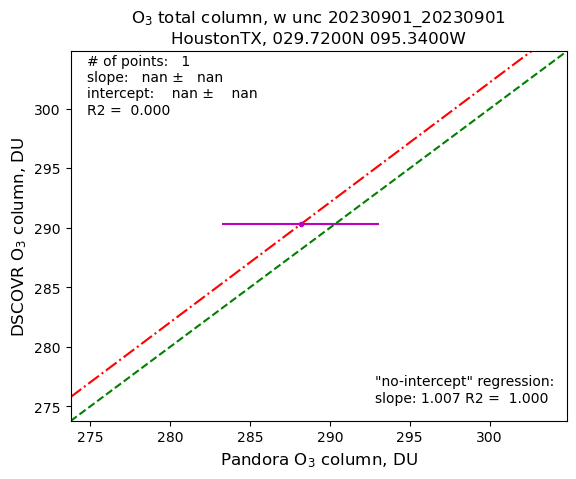

In [71]:
DSCOVR_Pandora_scatter = np.empty([0, 3])
for Dd in time_series_DSCOVR:
    for pd in timeseries_Pandora_DSCOVR:
        if Dd[0] == pd[0]:
            DSCOVR_Pandora_scatter = np.append(
                DSCOVR_Pandora_scatter, [[pd[1], Dd[1], pd[2]]], axis=0
            )
            break

regress = stats.linregress(DSCOVR_Pandora_scatter[:, 0], DSCOVR_Pandora_scatter[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept = regress_0intercept(
    DSCOVR_Pandora_scatter[:, 0], DSCOVR_Pandora_scatter[:, 1]
)

plot_title = "O$_{3}$ total column, w unc " + datestamp_ini + "_" + datestamp_fin + "\n" + POI_name
img_name = (
    "DSCOVR_vs_Pandora_scatter_O3_tot_col_unc_"
    + datestamp_ini
    + "_"
    + datestamp_fin
    + "_"
    + POI_name
    + ".jpg"
)

fig = plt.figure()

plt.errorbar(
    DSCOVR_Pandora_scatter[:, 0],
    DSCOVR_Pandora_scatter[:, 1],
    xerr=DSCOVR_Pandora_scatter[:, 2],
    c="m",
    ls="",
    marker=".",
)

plt.xlabel(r"Pandora O$_{3}$ column, DU", fontsize=12)
plt.ylabel(r"DSCOVR O$_{3}$ column, DU", fontsize=12)

fig.text(
    0.15,
    0.75,
    str(
        "# of points: %3i\nslope:%6.3f ±%6.3f\nintercept: %6.1f ± %6.1f\nR2 = %6.3f"
        % (len(DSCOVR_Pandora_scatter), slope, stderr, intercept, intercept_stderr, r2)
    ),
)

# Set the range of x-axis
l_lim = min(DSCOVR_Pandora_scatter[:, [0, 1]].flatten()) * 0.95
u_lim = max(DSCOVR_Pandora_scatter[:, [0, 1]].flatten()) * 1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim], c="g", ls="--")

plt.plot([l_lim, u_lim], [l_lim * slope + intercept, u_lim * slope + intercept], c="r", ls="--")

if success:
    plt.plot([l_lim, u_lim], [l_lim * slope_0intercept, u_lim * slope_0intercept], c="r", ls="-.")
    fig.text(
        0.6,
        0.15,
        str(
            '"no-intercept" regression:\nslope:%6.3f R2 = %6.3f' % (slope_0intercept, r2_0intercept)
        ),
    )

plt.title(plot_title + str(", %08.4fN %08.4fW" % (POI[0], -POI[1])))
plt.savefig(img_name, format="jpg", dpi=300)

# EXTRA. Archiving output files to make downloading easier

In [ ]:
import zipfile
import glob

In [ ]:
list_jpg = glob.glob("*" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".jpg")

with zipfile.ZipFile(
    "fig_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".zip", "w"
) as fig_zip:
    for name in list_jpg:
        fig_zip.write(name)

In [ ]:
list_data = glob.glob("*" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + "*.txt")

with zipfile.ZipFile(
    "data_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name + ".zip", "w"
) as data_zip:
    for name in list_data:
        data_zip.write(name)

In [ ]:
! rm *.nc
! rm *.h5

In [ ]:
list_jpg = glob.glob("*.jpg")

with zipfile.ZipFile("fig_all.zip", "w") as fig_zip:
    for name in list_jpg:
        fig_zip.write(name)

list_jpg = glob.glob("*.png")

with zipfile.ZipFile("fig_all.zip", "a") as fig_zip:
    for name in list_jpg:
        fig_zip.write(name)

In [72]:
!rm *.nc *.h5